# Face detection
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Change current working directory to project folder (1 mark)

In [0]:
import os
#### Add your code here ####
os.chdir('/content/drive/My Drive')

In [0]:
# IMPORT LIBRARIES AND PACKAGES
import csv
import math
import cv2

import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.layers import Concatenate, Conv2D, UpSampling2D, Reshape, BatchNormalization, Activation,ZeroPadding2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.regularizers import l2

### Load the "images.npy" file (4 marks)
- This file contains images with details of bounding boxes

In [0]:
import numpy as np
data = np.load('images.npy',mmap_mode=None, allow_pickle=True, fix_imports=True)

### Check one sample from the loaded "images.npy" file  (4 marks)

In [0]:
import matplotlib.pyplot as plt

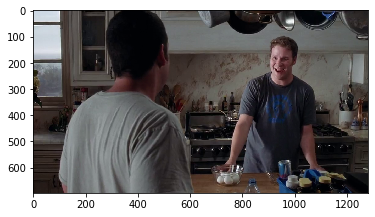

In [0]:
plt.imshow(data[1,0])

### Set image dimensions   (2 marks)
- Initialize image height, image width with value: 224 

In [0]:
data[1,1]

[{'imageHeight': 697,
  'imageWidth': 1280,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.7053087757313109, 'y': 0.23260437375745527},
   {'x': 0.7692307692307693, 'y': 0.36182902584493043}]}]

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

Y=np.zeros((409,4))
masks= np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
mask_img= np.zeros((int(data.shape[0]), 112, 112))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1  
    mask_img[index] = cv2.resize(masks[index], (112,112))

### Print the shape of X_train and mask array  (1 mark)

In [0]:
X_train.shape

(409, 224, 224, 3)

In [0]:
masks.shape

(409, 224, 224)

In [0]:
mask_img.shape

(409, 112, 112)

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

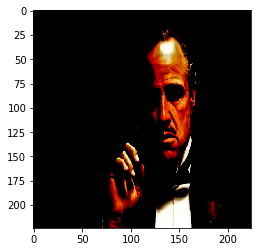

In [0]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

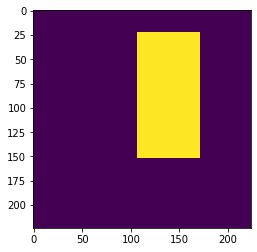

In [0]:
pyplot.imshow(masks[n])

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [0]:
model.weights.clear

<function list.clear>

In [0]:
ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

HEIGHT_CELLS =112
WIDTH_CELLS = 112

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

EPOCHS = 100
BATCH_SIZE = 1
PATIENCE = 10

THREADS = 1


LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.0005
LR_DECAY = 0.0001

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")
    OO=0
    for layer in model.layers:
        if OO>8:
          layer.trainable = trainable
        else:
           layer.trainable = False
        OO=OO+1

    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output
    block4 = model.get_layer("conv_pw_3_relu").output
    block5 = model.get_layer("conv_pw_1_relu").output
    block6 = model.get_layer("conv_pw_5_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x =BatchNormalization()(x)
    x = Concatenate()([UpSampling2D()(x), block1])
    x =BatchNormalization()(x)
    x = Concatenate()([UpSampling2D()(x), block4])
    x =BatchNormalization()(x)
    x = Concatenate()([UpSampling2D()(x), block5])
    x =BatchNormalization()(x)

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((112,112))(x)

    model = Model(inputs=model.input, outputs=x)

    # divide by 2 since d/dweight learning_rate * weight^2 = 2 * learning_rate * weight
    # see https://arxiv.org/pdf/1711.05101.pdf
    regularizer = l2(WEIGHT_DECAY / 2)
    for weight in model.trainable_weights:
        with tf.keras.backend.name_scope("weight_regularizer"):
            model.add_loss(regularizer(weight)) # in tf2.0: lambda: regularizer(weight)

    return model

### Call the create_model function

In [0]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model(False)

# Print summary0
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

### Define dice coefficient function (5 marks)
- Create a function to calculate dice coefficient


In [0]:
def dice_coef(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### Define loss

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss1(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred)- log(dice_coef(y_true, y_pred) + epsilon()) 

### Compile the model (5 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [0]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss1, optimizer="adam", metrics=[dice_coef])

### Define checkpoint and earlystopping

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model1-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="auto", period=1)
stop = EarlyStopping(monitor="val_loss", patience=PATIENCE, mode="auto")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="auto")

### Fit the model (5 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [0]:
masks.shape

(409, 224, 224)

In [0]:
mask_img.shape

(409, 112, 112)

In [0]:
from sklearn.model_selection import train_test_split
X,xx,Y,yy=train_test_split(X_train,mask_img,test_size=0.2)
model.fit(x=X,y=Y,batch_size=1,epochs=100,callbacks=[checkpoint, reduce_lr,stop],validation_data=(xx,yy))

Train on 327 samples, validate on 82 samples
Epoch 1/100
325/327 [============================>.] - ETA: 0s - loss: 1.2467 - dice_coef: 0.4681
Epoch 00001: val_loss improved from inf to 0.89125, saving model to model1-0.89.h5
327/327 [==============================] - 71s 216ms/sample - loss: 1.2445 - dice_coef: 0.4684 - val_loss: 0.8912 - val_dice_coef: 0.5737
Epoch 2/100
325/327 [============================>.] - ETA: 0s - loss: 1.0077 - dice_coef: 0.5404
Epoch 00002: val_loss did not improve from 0.89125
327/327 [==============================] - 17s 53ms/sample - loss: 1.0051 - dice_coef: 0.5413 - val_loss: 0.9633 - val_dice_coef: 0.5668
Epoch 3/100
325/327 [============================>.] - ETA: 0s - loss: 0.9530 - dice_coef: 0.5593
Epoch 00003: val_loss improved from 0.89125 to 0.85763, saving model to model1-0.86.h5
327/327 [==============================] - 18s 54ms/sample - loss: 0.9523 - dice_coef: 0.5590 - val_loss: 0.8576 - val_dice_coef: 0.5854
Epoch 4/100
326/327 [=======

### Get the predicted mask for a sample image   (5 marks)

In [0]:
import numpy as np
from keras.applications.mobilenet import preprocess_input

WEIGHTS_FILE ="model1-0.86.h5"
THRESHOLD = 0.8
EPSILON = 0.02

model = create_model()
model.load_weights(WEIGHTS_FILE)

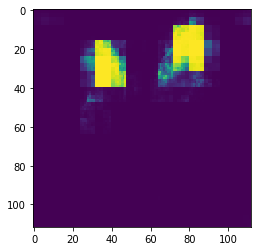

In [0]:
import matplotlib.pyplot as plt
filename =X_train[85].copy()
THRESHOLD = 0.8
EPSILON = 0.02

unscaled = filename
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

kk=model.predict(np.reshape(filename,(1,224,224,3)))
plt.imshow(np.reshape(kk,(112,112)))


### Impose the mask on the image (5 marks)

In [0]:
import numpy as np
def non_max_suppression_slow(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    pick = []

    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
  
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]

  
        for pos in range(0, last):
     
            j = idxs[pos]
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])

      
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)

            overlap = float(w * h) / area[j]
            if overlap > overlapThresh:
                suppress.append(pos)
        idxs = np.delete(idxs, suppress)

    return boxes[pick]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


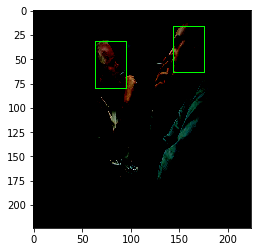

In [0]:
region=np.reshape(kk,(112,112))
output = np.zeros(unscaled.shape[:2], dtype=np.uint8)
for i in range(region.shape[1]):
    for j in range(region.shape[0]):
        if region[i][j] > THRESHOLD:
            x = int(j*2)
            y = int(i*2)
            x2 = int(2*(j + 1))
            y2 = int(2*(i + 1))
            #cv2.rectangle(unscaled, (x, y), (x2, y2), (0, 255, 0), 1)
            output[y:y2,x:x2] = 1

contours,_ = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
bb=[]
for cnt in contours:
    approx = cv2.approxPolyDP(cnt,EPSILON* cv2.arcLength(cnt, True), True)
    x, y, w, h = cv2.boundingRect(approx)
    bb.append((x,y,x+w,y+h))
box=non_max_suppression_slow(np.array(bb),0.5)
for po in box:
  cv2.rectangle(unscaled, (po[0], po[1]), (po[2], po[3]), (0, 255, 0), 1)

plt.imshow( unscaled)
cv2.waitKey(0)
cv2.destroyAllWindows()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


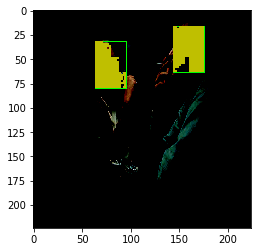

In [0]:
ccc=unscaled.copy()
for i in range(output.shape[0]):
  for j in range(output.shape[1]):
    if output[i,j]>0:
       ccc[i,j,0]=0.75
       ccc[i,j,1]=0.75
       ccc[i,j,2]=0

plt.imshow(ccc)
cv2.waitKey(0)
cv2.destroyAllWindows()

# lets make last few layers trainable

In [0]:
model1 = create_model(True)
model1.summary

<bound method Network.summary of <tensorflow.python.keras.engine.training.Model object at 0x7f70f416eeb8>>

In [0]:
model1.compile(loss=loss1, optimizer="adam", metrics=[dice_coef])
model1.fit(x=X,y=Y,batch_size=1,epochs=100,callbacks=[checkpoint, reduce_lr,stop],validation_data=(xx,yy))

Train on 327 samples, validate on 82 samples
Epoch 1/100
326/327 [============================>.] - ETA: 0s - loss: 1.2418 - dice_coef: 0.4933
Epoch 00001: val_loss did not improve from 0.51064
327/327 [==============================] - 35s 106ms/sample - loss: 1.2506 - dice_coef: 0.4923 - val_loss: 1.1716 - val_dice_coef: 0.5081
Epoch 2/100
326/327 [============================>.] - ETA: 0s - loss: 0.8495 - dice_coef: 0.6070
Epoch 00002: val_loss did not improve from 0.51064
327/327 [==============================] - 25s 76ms/sample - loss: 0.8492 - dice_coef: 0.6072 - val_loss: 1.2491 - val_dice_coef: 0.5240
Epoch 3/100
326/327 [============================>.] - ETA: 0s - loss: 0.7414 - dice_coef: 0.6448
Epoch 00003: val_loss did not improve from 0.51064
327/327 [==============================] - 25s 76ms/sample - loss: 0.7404 - dice_coef: 0.6451 - val_loss: 1.2888 - val_dice_coef: 0.5254
Epoch 4/100
326/327 [============================>.] - ETA: 0s - loss: 0.6225 - dice_coef: 0.691

The train dice coefficient is high.. but validation is low.. meaning the model is overfitting.. the data is not sufficient for increased number of parameters (with last few layers)

The dice coefficent for validation seems to be small lets try data agumentaion as the data size is small

## Model 2 with agumentations


In [0]:
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator()
aug = ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

xxx=aug.flow(X_train,seed=1,batch_size=1)
yyy=aug.flow(np.reshape(masks,((409, 224, 224,1))),seed=1,batch_size=1)

mm= []
XX = []

for i in range(300):
  ttt=xxx.next()
  fff=yyy.next()
  mm.append(fff)
  XX.append(ttt)

X_t=np.reshape(np.array(XX),(300,224,224,3))
m_t=np.reshape(np.array(mm),(300,224,224))

## An example of augumented image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


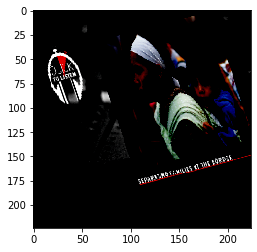

In [0]:
import matplotlib.pyplot as plt
plt.imshow(X_t[6])

## Its corresponding mask

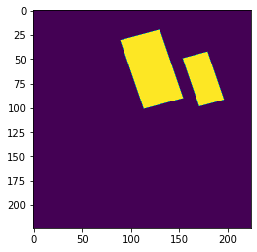

In [0]:
plt.imshow(m_t[6])

Creating 300 more images and mask by augumentation

In [0]:
maskm= np.zeros((300, 112, 112))
for index in range(300):
  maskm[index] = cv2.resize(m_t[index], (112,112))

In [0]:
X_t.shape

(300, 224, 224, 3)

In [0]:
from sklearn.model_selection import train_test_split
X,xx,Y,yy=train_test_split(X_train,mask_img,test_size=0.2)
XX=np.concatenate((X,X_t),axis=0)
YY=np.concatenate((Y,maskm))

In [0]:
YY.shape

(627, 112, 112)

In [0]:
XX.shape

(627, 224, 224, 3)

In [0]:
model2=create_model()

In [0]:
model2.compile(loss=loss1, optimizer="adam", metrics=[dice_coef])
model2.fit(XX,YY,epochs=100,callbacks=[checkpoint, reduce_lr,stop],validation_data=(xx,yy),batch_size=10)

Train on 627 samples, validate on 82 samples
Epoch 1/100
620/627 [============================>.] - ETA: 0s - loss: 1.1759 - dice_coef: 0.5310
Epoch 00001: val_loss did not improve from 0.85763
627/627 [==============================] - 39s 62ms/sample - loss: 1.1692 - dice_coef: 0.5332 - val_loss: 0.8684 - val_dice_coef: 0.6114
Epoch 2/100
620/627 [============================>.] - ETA: 0s - loss: 0.6350 - dice_coef: 0.6685
Epoch 00002: val_loss improved from 0.85763 to 0.73999, saving model to model1-0.74.h5
627/627 [==============================] - 93s 149ms/sample - loss: 0.6360 - dice_coef: 0.6682 - val_loss: 0.7400 - val_dice_coef: 0.6181
Epoch 3/100
620/627 [============================>.] - ETA: 0s - loss: 0.4872 - dice_coef: 0.7295
Epoch 00003: val_loss improved from 0.73999 to 0.72578, saving model to model1-0.73.h5
627/627 [==============================] - 32s 51ms/sample - loss: 0.4863 - dice_coef: 0.7300 - val_loss: 0.7258 - val_dice_coef: 0.6174
Epoch 4/100
620/627 [===

In [0]:
import numpy as np
from keras.applications.mobilenet import preprocess_input

WEIGHTS_FILE2 ="model1-0.51.h5"
THRESHOLD = 0.8
EPSILON = 0.02

model2 = create_model()
model2.load_weights(WEIGHTS_FILE2)

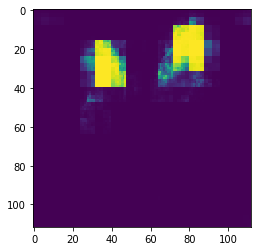

In [0]:
import matplotlib.pyplot as plt
filename =X_train[85].copy()
THRESHOLD = 0.8

EPSILON = 0.02

unscaled = filename
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

kk=model2.predict(np.reshape(filename,(1,224,224,3)))
plt.imshow(np.reshape(kk,(112,112)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


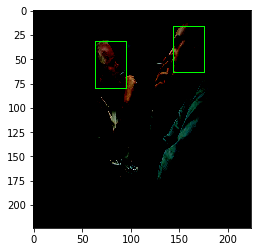

In [0]:
region=np.reshape(kk,(112,112))
output = np.zeros(unscaled.shape[:2], dtype=np.uint8)
for i in range(region.shape[1]):
    for j in range(region.shape[0]):
        if region[i][j] > THRESHOLD:
            x = int(j*2)
            y = int(i*2)
            x2 = int(2*(j + 1))
            y2 = int(2*(i + 1))
            #cv2.rectangle(unscaled, (x, y), (x2, y2), (0, 255, 0), 1)
            output[y:y2,x:x2] = 1

contours,_ = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
bb=[]
for cnt in contours:
    approx = cv2.approxPolyDP(cnt,EPSILON* cv2.arcLength(cnt, True), True)
    x, y, w, h = cv2.boundingRect(approx)
    bb.append((x,y,x+w,y+h))
box=non_max_suppression_slow(np.array(bb),0.5)
for po in box:
  cv2.rectangle(unscaled, (po[0], po[1]), (po[2], po[3]), (0, 255, 0), 1)

plt.imshow( unscaled)
cv2.waitKey(0)
cv2.destroyAllWindows()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


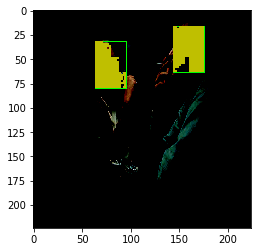

In [0]:
ccc=unscaled.copy()
for i in range(output.shape[0]):
  for j in range(output.shape[1]):
    if output[i,j]>0:
       ccc[i,j,0]=0.75
       ccc[i,j,1]=0.75
       ccc[i,j,2]=0

plt.imshow(ccc)
cv2.waitKey(0)
cv2.destroyAllWindows()

## The Validation dice coefficient increased with augumentaion.. lets try augumenting for 1000 Images

In [0]:
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator()
aug = ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

xxx=aug.flow(X_train,seed=1,batch_size=1)
yyy=aug.flow(np.reshape(masks,((409, 224, 224,1))),seed=1,batch_size=1)

mm= []
XX = []

for i in range(1000):
  ttt=xxx.next()
  fff=yyy.next()
  mm.append(fff)
  XX.append(ttt)

X_t=np.reshape(np.array(XX),(1000,224,224,3))
m_t=np.reshape(np.array(mm),(1000,224,224))

maskm= np.zeros((1000, 112, 112))
for index in range(1000):
  maskm[index] = cv2.resize(m_t[index], (112,112))

from sklearn.model_selection import train_test_split
X,xx,Y,yy=train_test_split(X_train,mask_img,test_size=0.2)
XX=np.concatenate((X,X_t),axis=0)
YY=np.concatenate((Y,maskm))

model3=create_model()

model3.compile(loss=loss1, optimizer="adam", metrics=[dice_coef])
model3.fit(XX,YY,epochs=100,callbacks=[checkpoint, reduce_lr,stop],validation_data=(xx,yy),batch_size=10)

Train on 1327 samples, validate on 82 samples
Epoch 1/100
1320/1327 [============================>.] - ETA: 0s - loss: 0.9624 - dice_coef: 0.5792
Epoch 00001: val_loss did not improve from 0.52948
1327/1327 [==============================] - 70s 53ms/sample - loss: 0.9612 - dice_coef: 0.5798 - val_loss: 0.7851 - val_dice_coef: 0.5966
Epoch 2/100
1320/1327 [============================>.] - ETA: 0s - loss: 0.5604 - dice_coef: 0.6944
Epoch 00002: val_loss did not improve from 0.52948
1327/1327 [==============================] - 65s 49ms/sample - loss: 0.5601 - dice_coef: 0.6947 - val_loss: 0.6001 - val_dice_coef: 0.6731
Epoch 3/100
1320/1327 [============================>.] - ETA: 0s - loss: 0.4348 - dice_coef: 0.7508
Epoch 00003: val_loss improved from 0.52948 to 0.52208, saving model to model1-0.52.h5
1327/1327 [==============================] - 100s 76ms/sample - loss: 0.4347 - dice_coef: 0.7509 - val_loss: 0.5221 - val_dice_coef: 0.7323
Epoch 4/100
1320/1327 [========================

In [0]:
import numpy as np
from keras.applications.mobilenet import preprocess_input

WEIGHTS_FILE3 ="model1-0.33.h5"
THRESHOLD = 0.8
EPSILON = 0.02

model3 = create_model()
model3.load_weights(WEIGHTS_FILE3)

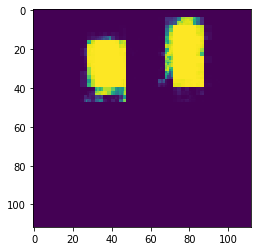

In [0]:
import matplotlib.pyplot as plt
filename =X_train[85].copy()
THRESHOLD = 0.8

EPSILON = 0.02

unscaled = filename
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

kk=model3.predict(np.reshape(filename,(1,224,224,3)))
plt.imshow(np.reshape(kk,(112,112)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


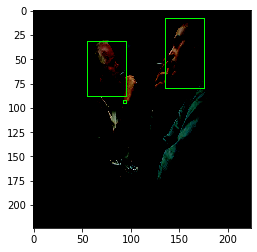

In [0]:
region=np.reshape(kk,(112,112))
output = np.zeros(unscaled.shape[:2], dtype=np.uint8)
for i in range(region.shape[1]):
    for j in range(region.shape[0]):
        if region[i][j] > THRESHOLD:
            x = int(j*2)
            y = int(i*2)
            x2 = int(2*(j + 1))
            y2 = int(2*(i + 1))
            #cv2.rectangle(unscaled, (x, y), (x2, y2), (0, 255, 0), 1)
            output[y:y2,x:x2] = 1

contours,_ = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
bb=[]
for cnt in contours:
    approx = cv2.approxPolyDP(cnt,EPSILON* cv2.arcLength(cnt, True), True)
    x, y, w, h = cv2.boundingRect(approx)
    bb.append((x,y,x+w,y+h))
box=non_max_suppression_slow(np.array(bb),0.5)
for po in box:
  cv2.rectangle(unscaled, (po[0], po[1]), (po[2], po[3]), (0, 255, 0), 1)
plt.imshow( unscaled)
cv2.waitKey(0)
cv2.destroyAllWindows()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


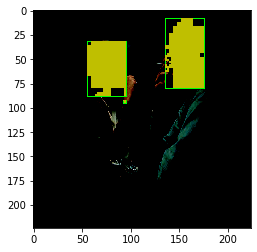

In [0]:
ccc=unscaled.copy()
for i in range(output.shape[0]):
  for j in range(output.shape[1]):
    if output[i,j]>0:
       ccc[i,j,0]=0.75
       ccc[i,j,1]=0.75
       ccc[i,j,2]=0

plt.imshow(ccc)
cv2.waitKey(0)
cv2.destroyAllWindows()

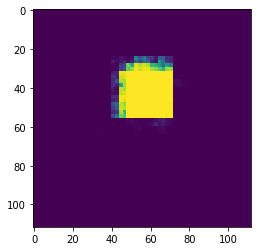

In [0]:
import matplotlib.pyplot as plt
filename =X_train[73].copy()
THRESHOLD = 0.8

EPSILON = 0.02

unscaled = filename
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

kk=model3.predict(np.reshape(filename,(1,224,224,3)))
plt.imshow(np.reshae(kk,(112,112)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


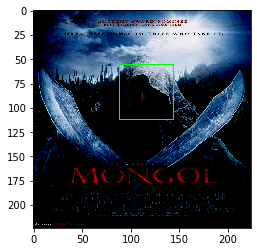

In [0]:
region=np.reshape(kk,(112,112))
output = np.zeros(unscaled.shape[:2], dtype=np.uint8)
for i in range(region.shape[1]):
    for j in range(region.shape[0]):
        if region[i][j] > THRESHOLD:
            x = int(j*2)
            y = int(i*2)
            x2 = int(2*(j + 1))
            y2 = int(2*(i + 1))
            #cv2.rectangle(unscaled, (x, y), (x2, y2), (0, 255, 0), 1)
            output[y:y2,x:x2] = 1

contours,_ = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
bb=[]
for cnt in contours:
    approx = cv2.approxPolyDP(cnt,EPSILON* cv2.arcLength(cnt, True), True)
    x, y, w, h = cv2.boundingRect(approx)
    bb.append((x,y,x+w,y+h))
box=non_max_suppression_slow(np.array(bb),0.5)
for po in box:
  cv2.rectangle(unscaled, (po[0], po[1]), (po[2], po[3]), (0, 255, 0), 1)
plt.imshow( unscaled)
cv2.waitKey(0)
cv2.destroyAllWindows()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


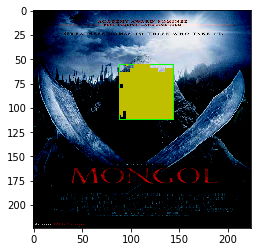

In [0]:
ccc=unscaled.copy()
for i in range(output.shape[0]):
  for j in range(output.shape[1]):
    if output[i,j]>0:
       ccc[i,j,0]=0.75
       ccc[i,j,1]=0.75
       ccc[i,j,2]=0

plt.imshow(ccc)
cv2.waitKey(0)
cv2.destroyAllWindows()

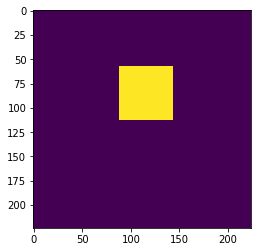

In [0]:
plt.imshow(masks[73])

# Summary

The feature extraction is done using mobile net with last few layers made trainable

The masks are used as y labels, and bounding boxes are made from the predicted masks

The non max suppression is used to suppress the overlapping boxes

The validation loss is reduced with increase in data samples by augumentaion